LGBM 01 con linear_tree = true

lags 1 al 36 (3 años)

cantidad de clientes que compraron un producto

meses de vida 

deltas tn de 1 a 36

In [1]:
# 📦 Importar librerías necesarias
import pandas as pd
import numpy as np
import random

# 🎲 Configurar semillas para reproductibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("✅ Librerías importadas correctamente")
print(f"🎲 Semilla configurada: {SEED} para reproductibilidad total")

✅ Librerías importadas correctamente
🎲 Semilla configurada: 42 para reproductibilidad total


In [2]:
# 📄 Cargar todos los datasets
print("Cargando datasets...")

# Load the sales data (tab-delimited)
sales = pd.read_csv("datasets/sell-in.txt", sep="\t", dtype={"periodo": str})
print(f"✅ Sales data cargado: {sales.shape}")

# Load the stocks data (tab-delimited) 
stocks = pd.read_csv("datasets/tb_stocks.txt", sep="\t", dtype={"periodo": str})
print(f"✅ Stocks data cargado: {stocks.shape}")

# Load the product information data (tab-delimited)
product_info = pd.read_csv("datasets/tb_productos.txt", sep="\t")
print(f"✅ Product info cargado: {product_info.shape}")

# Carga productos a predecir
product_predict = pd.read_csv("datasets/product_id_apredecir201912.txt", sep="\t", header=0)
print(f"✅ Productos a predecir cargados: {product_predict.shape}")

print("\n🎯 Todos los datasets cargados exitosamente")

Cargando datasets...
✅ Sales data cargado: (2945818, 7)
✅ Stocks data cargado: (13691, 3)
✅ Product info cargado: (1251, 7)
✅ Productos a predecir cargados: (780, 1)

🎯 Todos los datasets cargados exitosamente


In [3]:
# 🔍 Explorar estructura de los datos
print("EXPLORACIÓN DE DATOS")
print("="*50)

print("\n📊 SALES DATA:")
print(f"Columnas: {list(sales.columns)}")
print(f"Períodos únicos: {sales['periodo'].nunique()}")
print(f"Productos únicos: {sales['product_id'].nunique()}")
print("Primeras filas:")
print(sales.head())

print("\n📦 STOCKS DATA:")
print(f"Columnas: {list(stocks.columns)}")
print(f"Períodos únicos: {stocks['periodo'].nunique()}")
print(f"Productos únicos: {stocks['product_id'].nunique()}")
print("Primeras filas:")
print(stocks.head())

print("\n🏷️ PRODUCT INFO:")
print(f"Columnas: {list(product_info.columns)}")
print(f"Productos únicos: {product_info['product_id'].nunique()}")
print("Primeras filas:")
print(product_info.head())

print("\n🎯 PRODUCTOS A PREDECIR:")
print(f"Columnas: {list(product_predict.columns)}")
print(f"Total productos a predecir: {len(product_predict)}")
print("Primeras filas:")
print(product_predict.head())

EXPLORACIÓN DE DATOS

📊 SALES DATA:
Columnas: ['periodo', 'customer_id', 'product_id', 'plan_precios_cuidados', 'cust_request_qty', 'cust_request_tn', 'tn']
Períodos únicos: 36
Productos únicos: 1233
Primeras filas:
  periodo  customer_id  product_id  plan_precios_cuidados  cust_request_qty  \
0  201701        10234       20524                      0                 2   
1  201701        10032       20524                      0                 1   
2  201701        10217       20524                      0                 1   
3  201701        10125       20524                      0                 1   
4  201701        10012       20524                      0                11   

   cust_request_tn       tn  
0          0.05300  0.05300  
1          0.13628  0.13628  
2          0.03028  0.03028  
3          0.02271  0.02271  
4          1.54452  1.54452  

📦 STOCKS DATA:
Columnas: ['periodo', 'product_id', 'stock_final']
Períodos únicos: 15
Productos únicos: 1095
Primeras filas:
  p

In [4]:
# 🔗 Verificar consistencia entre datasets
print("VERIFICACIÓN DE CONSISTENCIA")
print("="*50)

# Productos únicos en cada dataset
productos_sales = set(sales['product_id'].unique())
productos_stocks = set(stocks['product_id'].unique())
productos_info = set(product_info['product_id'].unique())

# Si product_predict tiene columna product_id
if 'product_id' in product_predict.columns:
    productos_predict = set(product_predict['product_id'].unique())
else:
    # Si la primera columna contiene los product_ids
    primera_columna = product_predict.columns[0]
    productos_predict = set(product_predict[primera_columna].unique())
    print(f"⚠️ Usando columna '{primera_columna}' como product_id")

print(f"📊 Productos en sales: {len(productos_sales)}")
print(f"📦 Productos en stocks: {len(productos_stocks)}")
print(f"🏷️ Productos en product_info: {len(productos_info)}")
print(f"🎯 Productos a predecir: {len(productos_predict)}")

# Verificar intersecciones
print(f"\n🔍 INTERSECCIONES:")
print(f"Sales ∩ Stocks: {len(productos_sales & productos_stocks)}")
print(f"Sales ∩ Product_info: {len(productos_sales & productos_info)}")
print(f"Sales ∩ Productos_predict: {len(productos_sales & productos_predict)}")
print(f"Stocks ∩ Productos_predict: {len(productos_stocks & productos_predict)}")
print(f"Product_info ∩ Productos_predict: {len(productos_info & productos_predict)}")

# Verificar rangos de fechas
print(f"\n📅 RANGOS DE FECHAS:")
print(f"Sales - períodos: {sales['periodo'].min()} a {sales['periodo'].max()}")
print(f"Stocks - períodos: {stocks['periodo'].min()} a {stocks['periodo'].max()}")

VERIFICACIÓN DE CONSISTENCIA
📊 Productos en sales: 1233
📦 Productos en stocks: 1095
🏷️ Productos en product_info: 1251
🎯 Productos a predecir: 780

🔍 INTERSECCIONES:
Sales ∩ Stocks: 1095
Sales ∩ Product_info: 1188
Sales ∩ Productos_predict: 780
Stocks ∩ Productos_predict: 779
Product_info ∩ Productos_predict: 780

📅 RANGOS DE FECHAS:
Sales - períodos: 201701 a 201912
Stocks - períodos: 201810 a 201912


In [5]:
# 📦 Instalar e importar LightGBM, Optuna y librerías adicionales
# %pip install lightgbm optuna

import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 🎲 Configurar semillas adicionales para reproductibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Configurar semilla para matplotlib (si se usa)
plt.rcParams['figure.max_open_warning'] = 0

print("✅ LightGBM, Optuna y librerías ML importadas correctamente")
print(f"🎲 Todas las semillas configuradas con SEED={SEED} para reproductibilidad")

✅ LightGBM, Optuna y librerías ML importadas correctamente
🎲 Todas las semillas configuradas con SEED=42 para reproductibilidad


In [6]:
# 🧹 Preparación de datos para el modelo LightGBM
print("PREPARACIÓN DE DATOS PARA LGBM - GRANULARIDAD POR PRODUCTO")
print("="*60)

# Convertir período a datetime para facilitar manipulación
sales['fecha'] = pd.to_datetime(sales['periodo'], format='%Y%m')
stocks['fecha'] = pd.to_datetime(stocks['periodo'], format='%Y%m')

# Filtrar solo productos que necesitamos predecir
if 'product_id' in product_predict.columns:
    productos_objetivo = product_predict['product_id'].tolist()
else:
    productos_objetivo = product_predict[product_predict.columns[0]].tolist()

print(f"🎯 Productos objetivo: {len(productos_objetivo)}")

# Filtrar sales y stocks para productos objetivo
sales_filtered = sales[sales['product_id'].isin(productos_objetivo)].copy()
stocks_filtered = stocks[stocks['product_id'].isin(productos_objetivo)].copy()

print(f"📊 Sales filtradas: {sales_filtered.shape}")
print(f"📦 Stocks filtradas: {stocks_filtered.shape}")

# AGREGACIÓN POR PRODUCTO: Sumar por producto y período (agregando todos los clientes)
sales_agg = sales_filtered.groupby(['product_id', 'fecha', 'periodo']).agg({
    'tn': 'sum',                    # Total toneladas por producto
    'customer_id': 'nunique',       # Número de clientes únicos
    'cust_request_qty': 'sum',      # Total cantidad solicitada
    'cust_request_tn': 'sum'        # Total toneladas solicitadas
}).reset_index()

# Renombrar columnas para claridad
sales_agg.rename(columns={
    'customer_id': 'num_customers',
    'cust_request_qty': 'total_request_qty', 
    'cust_request_tn': 'total_request_tn'
}, inplace=True)

print(f"📈 Sales agregadas por producto: {sales_agg.shape}")
print("Primeras filas de sales agregadas:")
print(sales_agg.head())

print(f"\n📊 Estadísticas por producto:")
print(f"  Promedio tn por producto-período: {sales_agg['tn'].mean():.2f}")
print(f"  Promedio clientes por producto-período: {sales_agg['num_customers'].mean():.2f}")
print(f"  Productos únicos: {sales_agg['product_id'].nunique()}")
print(f"  Períodos únicos: {sales_agg['periodo'].nunique()}")

PREPARACIÓN DE DATOS PARA LGBM - GRANULARIDAD POR PRODUCTO
🎯 Productos objetivo: 780
📊 Sales filtradas: (2293481, 8)
📦 Stocks filtradas: (10727, 4)
📈 Sales agregadas por producto: (22349, 7)
Primeras filas de sales agregadas:
   product_id      fecha periodo          tn  num_customers  \
0       20001 2017-01-01  201701   934.77222            186   
1       20001 2017-02-01  201702   798.01620            185   
2       20001 2017-03-01  201703  1303.35771            188   
3       20001 2017-04-01  201704  1069.96130            104   
4       20001 2017-05-01  201705  1502.20132            238   

   total_request_qty  total_request_tn  
0                479         937.72717  
1                432         833.72187  
2                509        1330.74697  
3                279        1132.94430  
4                701        1550.68936  

📊 Estadísticas por producto:
  Promedio tn por producto-período: 50.23
  Promedio clientes por producto-período: 102.62
  Productos únicos: 780
  Pe

In [7]:
# 🔧 Crear features de lag y combinar con stocks - GRANULARIDAD POR PRODUCTO
print("CREACIÓN DE FEATURES POR PRODUCTO")
print("="*50)

# Crear features de lag para cada producto
def create_lag_features(df, product_col, value_col, date_col, lags=[1, 2, 3, 6, 12]):
    """Crear features de lag para series temporales por producto"""
    df_features = df.copy()
    df_features = df_features.sort_values([product_col, date_col])
    
    for lag in lags:
        df_features[f'{value_col}_lag_{lag}'] = df_features.groupby(product_col)[value_col].shift(lag)
    
    return df_features

# Crear lags para ventas (tn) por producto - EXPANDIDO HASTA LAG 36
sales_with_lags = create_lag_features(
    sales_agg, 
    'product_id', 
    'tn', 
    'fecha', 
    lags=list(range(1, 37))  # Todos los lags de 1 a 36 meses (3 años completos)
)

# Crear lags para número de clientes por producto
sales_with_lags = create_lag_features(
    sales_with_lags, 
    'product_id', 
    'num_customers', 
    'fecha', 
    lags=[1, 2, 3]
)

# Crear lags para solicitudes de clientes
sales_with_lags = create_lag_features(
    sales_with_lags, 
    'product_id', 
    'total_request_tn', 
    'fecha', 
    lags=[1, 2, 3]
)

print(f"📊 Sales con lags por producto: {sales_with_lags.shape}")

# Agregar datos de stock por producto
stocks_agg = stocks_filtered.groupby(['product_id', 'fecha', 'periodo']).agg({
    'stock_final': ['mean', 'sum', 'std']  # Stock promedio, total y desviación estándar por producto
}).reset_index()

# Aplanar columnas multinivel
stocks_agg.columns = ['product_id', 'fecha', 'periodo', 'stock_tn_mean', 'stock_tn_sum', 'stock_tn_std']
stocks_agg['stock_tn_std'] = stocks_agg['stock_tn_std'].fillna(0)  # Rellenar NaN en std

# Combinar sales y stocks por producto
data_combined = pd.merge(
    sales_with_lags, 
    stocks_agg[['product_id', 'fecha', 'stock_tn_mean', 'stock_tn_sum', 'stock_tn_std']], 
    on=['product_id', 'fecha'], 
    how='left'
)

# Crear lags para stock por producto
data_combined = create_lag_features(
    data_combined, 
    'product_id', 
    'stock_tn_mean', 
    'fecha', 
    lags=[1, 2, 3]
)

data_combined = create_lag_features(
    data_combined, 
    'product_id', 
    'stock_tn_sum', 
    'fecha', 
    lags=[1, 2]
)

print(f"📦 Datos combinados con stock por producto: {data_combined.shape}")
print(f"Columnas disponibles: {len(data_combined.columns)}")
print("\nPrimeras columnas:")
print(data_combined.columns.tolist()[:15])
print("Últimas columnas:")
print(data_combined.columns.tolist()[-10:])

CREACIÓN DE FEATURES POR PRODUCTO
📊 Sales con lags por producto: (22349, 49)
📦 Datos combinados con stock por producto: (22349, 57)
Columnas disponibles: 57

Primeras columnas:
['product_id', 'fecha', 'periodo', 'tn', 'num_customers', 'total_request_qty', 'total_request_tn', 'tn_lag_1', 'tn_lag_2', 'tn_lag_3', 'tn_lag_4', 'tn_lag_5', 'tn_lag_6', 'tn_lag_7', 'tn_lag_8']
Últimas columnas:
['total_request_tn_lag_2', 'total_request_tn_lag_3', 'stock_tn_mean', 'stock_tn_sum', 'stock_tn_std', 'stock_tn_mean_lag_1', 'stock_tn_mean_lag_2', 'stock_tn_mean_lag_3', 'stock_tn_sum_lag_1', 'stock_tn_sum_lag_2']


In [8]:
# 🎯 Crear target y features adicionales
print("CREACIÓN DE TARGET Y FEATURES ADICIONALES")
print("="*50)

# Crear target: tn de 2 períodos a futuro
data_combined = data_combined.sort_values(['product_id', 'fecha'])
data_combined['target'] = data_combined.groupby('product_id')['tn'].shift(-2)

# Crear features temporales
data_combined['mes'] = data_combined['fecha'].dt.month
data_combined['trimestre'] = data_combined['fecha'].dt.quarter
data_combined['año'] = data_combined['fecha'].dt.year

# 🔢 Crear feature de clientes únicos por producto
print(f"\n🔍 Creando feature de clientes únicos por producto...")
# Calcular cantidad total de clientes únicos que compraron cada producto
clientes_unicos_por_producto = sales_filtered.groupby('product_id')['customer_id'].nunique().reset_index()
clientes_unicos_por_producto.rename(columns={'customer_id': 'cant_clientes_unicos'}, inplace=True)

# Agregar esta información a data_combined
data_combined = pd.merge(
    data_combined,
    clientes_unicos_por_producto,
    on='product_id',
    how='left'
)

print(f"✅ Feature 'cant_clientes_unicos' agregada")
print(f"📊 Estadísticas de clientes únicos por producto:")
print(f"   Promedio: {data_combined['cant_clientes_unicos'].mean():.1f}")
print(f"   Mediana:  {data_combined['cant_clientes_unicos'].median():.1f}")
print(f"   Mínimo:   {data_combined['cant_clientes_unicos'].min()}")
print(f"   Máximo:   {data_combined['cant_clientes_unicos'].max()}")

# 🗓️ Crear feature de meses de vida por producto
print(f"\n🔍 Creando feature de meses de vida por producto...")
# Calcular primer y último período de compra para cada producto
vida_producto = sales_filtered.groupby('product_id')['fecha'].agg(['min', 'max']).reset_index()
vida_producto.columns = ['product_id', 'primer_periodo', 'ultimo_periodo']

# Calcular diferencia en meses
vida_producto['meses_vida'] = ((vida_producto['ultimo_periodo'] - vida_producto['primer_periodo']).dt.days / 30.44).round().astype(int)

# Asegurar que el mínimo sea 1 (productos con una sola compra tienen 1 mes de vida)
vida_producto['meses_vida'] = vida_producto['meses_vida'].apply(lambda x: max(1, x))

# Agregar esta información a data_combined
data_combined = pd.merge(
    data_combined,
    vida_producto[['product_id', 'meses_vida']],
    on='product_id',
    how='left'
)

print(f"✅ Feature 'meses_vida' agregada")
print(f"📊 Estadísticas de meses de vida por producto:")
print(f"   Promedio: {data_combined['meses_vida'].mean():.1f} meses")
print(f"   Mediana:  {data_combined['meses_vida'].median():.1f} meses")
print(f"   Mínimo:   {data_combined['meses_vida'].min()} meses")
print(f"   Máximo:   {data_combined['meses_vida'].max()} meses")
print(f"   Productos con > 24 meses: {(data_combined['meses_vida'] > 24).sum()}")
print(f"   Productos con > 36 meses: {(data_combined['meses_vida'] > 36).sum()}")

# 📈 Crear features de deltas temporales (diferencias del target)
print(f"\n🔍 Creando features de deltas temporales del target...")
# Calcular diferencias entre valores actuales y rezagados de toneladas
data_combined = data_combined.sort_values(['product_id', 'fecha'])

# Deltas de corto plazo (1-6 meses)
data_combined['delta_tn_1m'] = data_combined.groupby('product_id')['tn'].diff(1)  # Cambio vs mes anterior
data_combined['delta_tn_3m'] = data_combined.groupby('product_id')['tn'].diff(3)  # Cambio vs 3 meses atrás
data_combined['delta_tn_6m'] = data_combined.groupby('product_id')['tn'].diff(6)  # Cambio vs 6 meses atrás

# Deltas de mediano plazo (12-18 meses)
data_combined['delta_tn_12m'] = data_combined.groupby('product_id')['tn'].diff(12)  # Cambio vs 12 meses atrás (estacional anual)
data_combined['delta_tn_18m'] = data_combined.groupby('product_id')['tn'].diff(18)  # Cambio vs 18 meses atrás

# Deltas de largo plazo (24-36 meses)
data_combined['delta_tn_24m'] = data_combined.groupby('product_id')['tn'].diff(24)  # Cambio vs 24 meses atrás (bi-anual)
data_combined['delta_tn_30m'] = data_combined.groupby('product_id')['tn'].diff(30)  # Cambio vs 30 meses atrás
data_combined['delta_tn_36m'] = data_combined.groupby('product_id')['tn'].diff(36)  # Cambio vs 36 meses atrás (tri-anual)

# Deltas relativos (porcentuales) para capturar cambios relativos
data_combined['delta_tn_1m_pct'] = data_combined.groupby('product_id')['tn'].pct_change(1) * 100  # % cambio vs mes anterior
data_combined['delta_tn_12m_pct'] = data_combined.groupby('product_id')['tn'].pct_change(12) * 100  # % cambio vs año anterior
data_combined['delta_tn_24m_pct'] = data_combined.groupby('product_id')['tn'].pct_change(24) * 100  # % cambio vs 2 años anterior
data_combined['delta_tn_36m_pct'] = data_combined.groupby('product_id')['tn'].pct_change(36) * 100  # % cambio vs 3 años anterior

# Reemplazar infinitos y NaN con 0
delta_features = ['delta_tn_1m', 'delta_tn_3m', 'delta_tn_6m', 'delta_tn_12m', 'delta_tn_18m', 'delta_tn_24m', 'delta_tn_30m', 'delta_tn_36m', 'delta_tn_1m_pct', 'delta_tn_12m_pct', 'delta_tn_24m_pct', 'delta_tn_36m_pct']
for feature in delta_features:
    data_combined[feature] = data_combined[feature].replace([np.inf, -np.inf], 0).fillna(0)

print(f"✅ Features de deltas temporales agregadas")
print(f"📊 Estadísticas de deltas temporales:")
print(f"   Delta 1 mes - promedio: {data_combined['delta_tn_1m'].mean():.2f}")
print(f"   Delta 12 meses - promedio: {data_combined['delta_tn_12m'].mean():.2f}")
print(f"   Delta 24 meses - promedio: {data_combined['delta_tn_24m'].mean():.2f}")
print(f"   Delta 36 meses - promedio: {data_combined['delta_tn_36m'].mean():.2f}")
print(f"   Delta 1 mes % - promedio: {data_combined['delta_tn_1m_pct'].mean():.2f}%")
print(f"   Delta 12 meses % - promedio: {data_combined['delta_tn_12m_pct'].mean():.2f}%")
print(f"   Delta 24 meses % - promedio: {data_combined['delta_tn_24m_pct'].mean():.2f}%")
print(f"   Delta 36 meses % - promedio: {data_combined['delta_tn_36m_pct'].mean():.2f}%")
print(f"   Features creadas: {delta_features}")
print(f"🎯 Deltas expandidos: Captura tendencias hasta 36 meses atrás")

# Crear features estadísticas móviles
def create_rolling_features(df, product_col, value_col, date_col, windows=[3, 6, 12]):
    """Crear features de ventanas móviles"""
    df = df.sort_values([product_col, date_col])
    
    for window in windows:
        df[f'{value_col}_rolling_mean_{window}'] = df.groupby(product_col)[value_col].rolling(window, min_periods=1).mean().reset_index(level=0, drop=True)
        df[f'{value_col}_rolling_std_{window}'] = df.groupby(product_col)[value_col].rolling(window, min_periods=1).std().reset_index(level=0, drop=True)
    
    return df

# Crear rolling features para ventas
data_combined = create_rolling_features(data_combined, 'product_id', 'tn', 'fecha', windows=[3, 6])

# 📊 Verificar features de lags de toneladas creados
print(f"\n📈 FEATURES DE LAGS DE TONELADAS DISPONIBLES:")
tn_lag_features = [col for col in data_combined.columns if col.startswith('tn_lag_')]
tn_lag_features.sort(key=lambda x: int(x.split('_')[-1]))  # Ordenar por número de lag
print(f"   Total de lags de toneladas: {len(tn_lag_features)}")
for i, feature in enumerate(tn_lag_features, 1):
    lag_num = feature.split('_')[-1]
    print(f"   {i:2d}. {feature} (toneladas de {lag_num} mes{'es' if int(lag_num) > 1 else ''} atrás)")

print(f"\n✅ Features expandidas: Lags de toneladas desde 1 hasta 36 meses")
print(f"🎯 Esto permite al modelo capturar patrones estacionales multi-anuales")

# Agregar información de productos si está disponible
if len(product_info) > 0:
    data_combined = pd.merge(
        data_combined, 
        product_info, 
        on='product_id', 
        how='left'
    )
    print(f"✅ Información de productos agregada")

print(f"📊 Dataset final: {data_combined.shape}")
print(f"📈 Registros con target válido: {data_combined['target'].notna().sum()}")

# Mostrar algunas estadísticas del target
target_stats = data_combined['target'].describe()
print(f"\n📊 Estadísticas del target:")
print(target_stats)

CREACIÓN DE TARGET Y FEATURES ADICIONALES

🔍 Creando feature de clientes únicos por producto...
✅ Feature 'cant_clientes_unicos' agregada
📊 Estadísticas de clientes únicos por producto:
   Promedio: 359.6
   Mediana:  372.0
   Mínimo:   22
   Máximo:   521

🔍 Creando feature de meses de vida por producto...
✅ Feature 'meses_vida' agregada
📊 Estadísticas de meses de vida por producto:
   Promedio: 31.9 meses
   Mediana:  35.0 meses
   Mínimo:   3 meses
   Máximo:   35 meses
   Productos con > 24 meses: 19798
   Productos con > 36 meses: 0

🔍 Creando features de deltas temporales del target...
✅ Features de deltas temporales agregadas
📊 Estadísticas de deltas temporales:
   Delta 1 mes - promedio: -0.26
   Delta 12 meses - promedio: -3.92
   Delta 24 meses - promedio: -3.95
   Delta 36 meses - promedio: 0.00
   Delta 1 mes % - promedio: 126.68%
   Delta 12 meses % - promedio: 49.11%
   Delta 24 meses % - promedio: 68.49%
   Delta 36 meses % - promedio: 0.00%
   Features creadas: ['delta_

In [ ]:
# 📋 Preparar datos para entrenamiento - GRANULARIDAD POR PRODUCTO
print("PREPARACIÓN DE DATOS DE ENTRENAMIENTO POR PRODUCTO")
print("="*60)

# Filtrar registros con target válido
train_data = data_combined[data_combined['target'].notna()].copy()
print(f"📊 Registros válidos para entrenamiento: {len(train_data)}")

# Seleccionar features para el modelo con granularidad por producto
feature_columns = [
    # Lags de ventas (tn) por producto - EXPANDIDO A 36 LAGS (3 AÑOS)
    'tn_lag_1', 'tn_lag_2', 'tn_lag_3', 'tn_lag_4', 'tn_lag_5', 'tn_lag_6',
    'tn_lag_7', 'tn_lag_8', 'tn_lag_9', 'tn_lag_10', 'tn_lag_11', 'tn_lag_12',
    'tn_lag_13', 'tn_lag_14', 'tn_lag_15', 'tn_lag_16', 'tn_lag_17', 'tn_lag_18',
    'tn_lag_19', 'tn_lag_20', 'tn_lag_21', 'tn_lag_22', 'tn_lag_23', 'tn_lag_24',
    'tn_lag_25', 'tn_lag_26', 'tn_lag_27', 'tn_lag_28', 'tn_lag_29', 'tn_lag_30',
    'tn_lag_31', 'tn_lag_32', 'tn_lag_33', 'tn_lag_34', 'tn_lag_35', 'tn_lag_36',
    
    # Lags de clientes por producto
    'num_customers_lag_1', 'num_customers_lag_2', 'num_customers_lag_3',
    
    # Lags de solicitudes por producto
    'total_request_tn_lag_1', 'total_request_tn_lag_2', 'total_request_tn_lag_3',
    
    # Lags de stock por producto
    'stock_tn_mean_lag_1', 'stock_tn_mean_lag_2', 'stock_tn_mean_lag_3',
    'stock_tn_sum_lag_1', 'stock_tn_sum_lag_2',
    
    # Features temporales
    'mes', 'trimestre', 'año',
    
    # Rolling features por producto
    'tn_rolling_mean_3', 'tn_rolling_mean_6',
    'tn_rolling_std_3', 'tn_rolling_std_6',
    
    # Features actuales por producto
    'num_customers', 'total_request_qty', 'total_request_tn',
    'stock_tn_mean', 'stock_tn_sum', 'stock_tn_std',
    
    # Feature de diversidad de clientes
    'cant_clientes_unicos',
    
    # Feature de longevidad del producto
    'meses_vida',
    
    # Features de deltas temporales (expandidas hasta 36 meses)
    'delta_tn_1m', 'delta_tn_3m', 'delta_tn_6m', 'delta_tn_12m', 'delta_tn_18m', 'delta_tn_24m', 'delta_tn_30m', 'delta_tn_36m',
    'delta_tn_1m_pct', 'delta_tn_12m_pct', 'delta_tn_24m_pct', 'delta_tn_36m_pct'
]

# Verificar qué features existen
available_features = [col for col in feature_columns if col in train_data.columns]
missing_features = [col for col in feature_columns if col not in train_data.columns]

print(f"✅ Features disponibles: {len(available_features)}")
print(f"⚠️ Features faltantes: {len(missing_features)}")
if missing_features:
    print(f"Features faltantes: {missing_features}")

# Usar solo features disponibles
feature_columns = available_features

# Preparar X e y
X = train_data[feature_columns].copy()
y = train_data['target'].copy()

# Rellenar valores nulos con 0 (para lags iniciales y stocks faltantes)
X = X.fillna(0)

print(f"📊 Shape de X: {X.shape}")
print(f"📈 Shape de y: {y.shape}")
print(f"🔍 Valores nulos en X: {X.isnull().sum().sum()}")
print(f"🔍 Valores nulos en y: {y.isnull().sum()}")

# # División temporal para validación (últimos períodos como validación)
# train_data_sorted = train_data.sort_values('fecha')
# split_date = train_data_sorted['fecha'].quantile(0.8)  # 80% entrenamiento, 20% validación

# División temporal para validación usando fecha 201910
split_date = pd.to_datetime('201910', format='%Y%m')
train_mask = train_data['fecha'] < split_date

X_train = X.loc[train_mask]
X_val = X.loc[~train_mask] 
y_train = y.loc[train_mask]
y_val = y.loc[~train_mask]

print(f"\n📊 DIVISIÓN TEMPORAL:")
print(f"Entrenamiento: {len(X_train)} registros (hasta {split_date.strftime('%Y-%m')})")
print(f"Validación: {len(X_val)} registros (desde {split_date.strftime('%Y-%m')})")

print(f"\n🎯 PRODUCTOS EN ENTRENAMIENTO:")
productos_train = train_data.loc[train_mask, 'product_id'].nunique()
productos_val = train_data.loc[~train_mask, 'product_id'].nunique()
print(f"Productos únicos en entrenamiento: {productos_train}")
print(f"Productos únicos en validación: {productos_val}")

print(f"\nFeatures seleccionadas para granularidad por producto:")
for i, feat in enumerate(feature_columns):
    print(f"  {i+1:2d}. {feat}")

PREPARACIÓN DE DATOS DE ENTRENAMIENTO POR PRODUCTO
📊 Registros válidos para entrenamiento: 20789
✅ Features disponibles: 74
⚠️ Features faltantes: 0
📊 Shape de X: (20789, 74)
📈 Shape de y: (20789,)
🔍 Valores nulos en X: 0
🔍 Valores nulos en y: 0

📊 DIVISIÓN TEMPORAL:
Entrenamiento: 20009 registros (hasta 2019-10)
Validación: 780 registros (desde 2019-10)

🎯 PRODUCTOS EN ENTRENAMIENTO:
Productos únicos en entrenamiento: 780
Productos únicos en validación: 780

Features seleccionadas para granularidad por producto:
   1. tn_lag_1
   2. tn_lag_2
   3. tn_lag_3
   4. tn_lag_4
   5. tn_lag_5
   6. tn_lag_6
   7. tn_lag_7
   8. tn_lag_8
   9. tn_lag_9
  10. tn_lag_10
  11. tn_lag_11
  12. tn_lag_12
  13. tn_lag_13
  14. tn_lag_14
  15. tn_lag_15
  16. tn_lag_16
  17. tn_lag_17
  18. tn_lag_18
  19. tn_lag_19
  20. tn_lag_20
  21. tn_lag_21
  22. tn_lag_22
  23. tn_lag_23
  24. tn_lag_24
  25. tn_lag_25
  26. tn_lag_26
  27. tn_lag_27
  28. tn_lag_28
  29. tn_lag_29
  30. tn_lag_30
  31. tn_l

In [10]:
# 📊 Resumen detallado de features con lags de toneladas expandidos
print("RESUMEN DETALLADO DE FEATURES CON LAGS EXPANDIDOS")
print("="*60)

# Agrupar features por categoría
tn_lags = [f for f in feature_columns if f.startswith('tn_lag_')]
customer_lags = [f for f in feature_columns if f.startswith('num_customers_lag_')]
request_lags = [f for f in feature_columns if f.startswith('total_request_tn_lag_')]
stock_lags = [f for f in feature_columns if f.startswith('stock_tn_')]
temporal_features = [f for f in feature_columns if f in ['mes', 'trimestre', 'año']]
rolling_features = [f for f in feature_columns if 'rolling' in f]
current_features = [f for f in feature_columns if f in ['num_customers', 'total_request_qty', 'total_request_tn', 'stock_tn_mean', 'stock_tn_sum', 'stock_tn_std', 'cant_clientes_unicos', 'meses_vida', 'delta_tn_1m', 'delta_tn_3m', 'delta_tn_6m', 'delta_tn_12m', 'delta_tn_18m', 'delta_tn_24m', 'delta_tn_30m', 'delta_tn_36m', 'delta_tn_1m_pct', 'delta_tn_12m_pct', 'delta_tn_24m_pct', 'delta_tn_36m_pct']]

print(f"📈 LAGS DE TONELADAS (EXPANDIDOS A 36): {len(tn_lags)} features")
tn_lags_sorted = sorted(tn_lags, key=lambda x: int(x.split('_')[-1]))
for i, lag in enumerate(tn_lags_sorted, 1):
    lag_num = lag.split('_')[-1]
    print(f"   {i:2d}. {lag} (ventas de {lag_num} mes{'es' if int(lag_num) > 1 else ''} atrás)")

print(f"\n👥 LAGS DE CLIENTES: {len(customer_lags)} features")
for i, lag in enumerate(customer_lags, 1):
    print(f"   {i}. {lag}")

print(f"\n📋 LAGS DE SOLICITUDES: {len(request_lags)} features")
for i, lag in enumerate(request_lags, 1):
    print(f"   {i}. {lag}")

print(f"\n📦 FEATURES DE STOCK: {len(stock_lags)} features")
for i, lag in enumerate(stock_lags, 1):
    print(f"   {i}. {lag}")

print(f"\n📅 FEATURES TEMPORALES: {len(temporal_features)} features")
for i, feat in enumerate(temporal_features, 1):
    print(f"   {i}. {feat}")

print(f"\n📊 FEATURES ROLLING: {len(rolling_features)} features")
for i, feat in enumerate(rolling_features, 1):
    print(f"   {i}. {feat}")

print(f"\n🔄 FEATURES ACTUALES: {len(current_features)} features")
for i, feat in enumerate(current_features, 1):
    print(f"   {i}. {feat}")

print(f"\n✅ TOTAL DE FEATURES: {len(feature_columns)}")
print(f"🎯 MEJORA PRINCIPAL: Lags de toneladas expandidos de 12 → 36 features")
print(f"🔢 NUEVA FEATURE: cant_clientes_unicos (diversidad de base de clientes)")
print(f"🗓️ NUEVA FEATURE: meses_vida (longevidad del producto en el mercado)")
print(f"📈 NUEVAS FEATURES: deltas temporales expandidas (tendencias hasta 36 meses)")
print(f"📊 Esto permite capturar:")
print(f"   • Patrones estacionales anuales completos (12 meses)")
print(f"   • Patrones estacionales bi-anuales (24 meses)")
print(f"   • Patrones estacionales tri-anuales (36 meses)")
print(f"   • Tendencias de corto plazo (1-6 meses)")
print(f"   • Tendencias de mediano plazo (7-18 meses)")
print(f"   • Tendencias de largo plazo (19-36 meses)")
print(f"   • Ciclos multi-anuales y efectos estacionales profundos")
print(f"   • Diversidad de base de clientes por producto")
print(f"   • Madurez y longevidad del producto en el mercado")
print(f"   • Cambios y tendencias temporales hasta 3 años atrás")
print(f"   • Velocidad de cambio en ventas (aceleración/desaceleración)")
print(f"   • Comparaciones tri-anuales para detectar ciclos largos")

RESUMEN DETALLADO DE FEATURES CON LAGS EXPANDIDOS
📈 LAGS DE TONELADAS (EXPANDIDOS A 36): 36 features
    1. tn_lag_1 (ventas de 1 mes atrás)
    2. tn_lag_2 (ventas de 2 meses atrás)
    3. tn_lag_3 (ventas de 3 meses atrás)
    4. tn_lag_4 (ventas de 4 meses atrás)
    5. tn_lag_5 (ventas de 5 meses atrás)
    6. tn_lag_6 (ventas de 6 meses atrás)
    7. tn_lag_7 (ventas de 7 meses atrás)
    8. tn_lag_8 (ventas de 8 meses atrás)
    9. tn_lag_9 (ventas de 9 meses atrás)
   10. tn_lag_10 (ventas de 10 meses atrás)
   11. tn_lag_11 (ventas de 11 meses atrás)
   12. tn_lag_12 (ventas de 12 meses atrás)
   13. tn_lag_13 (ventas de 13 meses atrás)
   14. tn_lag_14 (ventas de 14 meses atrás)
   15. tn_lag_15 (ventas de 15 meses atrás)
   16. tn_lag_16 (ventas de 16 meses atrás)
   17. tn_lag_17 (ventas de 17 meses atrás)
   18. tn_lag_18 (ventas de 18 meses atrás)
   19. tn_lag_19 (ventas de 19 meses atrás)
   20. tn_lag_20 (ventas de 20 meses atrás)
   21. tn_lag_21 (ventas de 21 meses at

In [11]:
# 🔧 Optimización de hiperparámetros con Optuna para LINEAR_TREE
print("OPTIMIZACIÓN DE HIPERPARÁMETROS CON OPTUNA - LINEAR_TREE")
print("="*60)

# 🎲 Configurar semilla para Optuna y reproductibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

def objective(trial):
    """Función objetivo para optimización con Optuna incluyendo linear_tree"""
    
    # 🎲 Configurar semilla para cada trial
    np.random.seed(SEED + trial.number)
    random.seed(SEED + trial.number)
    
    # Sugerir hiperparámetros optimizados para linear_tree
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'linear_tree': True,        # FIJO: Característica principal del modelo
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 2.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 2.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 120),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 40),
        'max_bin': trial.suggest_int('max_bin', 100, 400),
        'verbose': -1,
        'random_state': SEED + trial.number,  # Semilla única por trial
        'bagging_seed': SEED + trial.number,  # Semilla para bagging
        'feature_fraction_seed': SEED + trial.number  # Semilla para feature selection
    }
    
    # Crear datasets de LightGBM
    train_dataset = lgb.Dataset(X_train, label=y_train)
    val_dataset = lgb.Dataset(X_val, label=y_val, reference=train_dataset)
    
    # Entrenar modelo con validación cruzada interna
    model = lgb.train(
        params,
        train_dataset,
        valid_sets=[val_dataset],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(0)  # Silenciar logs
        ]
    )
    
    # Predecir en conjunto de validación
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    # Calcular MAE como métrica a minimizar
    mae = mean_absolute_error(y_val, y_pred)
    
    return mae

# Crear estudio de optimización
print("🔍 Iniciando optimización de hiperparámetros con LINEAR_TREE...")
print(f"🎲 Usando semilla base {SEED} para reproducibilidad completa")

study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=SEED),  # Semilla para el sampler
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)

# Ejecutar optimización
n_trials = 500 #Número de pruebas
print(f"🚀 Ejecutando {n_trials} trials de optimización para LINEAR_TREE...")
print(f"🎲 Cada trial usa semilla: SEED + trial_number para reproductibilidad")

study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

# Mostrar mejores parámetros
print(f"\n✅ Optimización completada!")
print(f"🏆 Mejor MAE encontrado: {study.best_value:.4f}")
print(f"\n🔧 HIPERPARÁMETROS OPTIMIZADOS PARA LINEAR_TREE:")
best_params = study.best_params
print("="*65)
print(f"   linear_tree:      True (FIJO - Característica principal) ⭐")
print(f"   lambda_l1:        {best_params['lambda_l1']:.4f}")
print(f"   lambda_l2:        {best_params['lambda_l2']:.4f}")
print(f"   num_leaves:       {best_params['num_leaves']}")
print(f"   feature_fraction: {best_params['feature_fraction']:.4f}")
print(f"   learning_rate:    {best_params['learning_rate']:.4f}")
print(f"   bagging_fraction: {best_params['bagging_fraction']:.4f}")
print(f"   bagging_freq:     {best_params['bagging_freq']}")
print(f"   min_child_samples: {best_params['min_child_samples']}")
print(f"   max_bin:          {best_params['max_bin']}")
print("="*65)

# Agregar parámetros fijos
best_params.update({
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'linear_tree': True,  # Mantener como característica principal
    'verbose': 0,
    'random_state': SEED,  # Semilla principal para el modelo final
    'bagging_seed': SEED,  # Semilla para bagging
    'feature_fraction_seed': SEED,  # Semilla para feature selection
    'data_seed': SEED  # Semilla para datos
})

print(f"\n📊 Resumen de la optimización:")
print(f"  Trials completados: {len(study.trials)}")
print(f"  Mejor trial: {study.best_trial.number}")
print(f"  Tiempo total: {sum(t.duration.total_seconds() for t in study.trials if t.duration):.1f} segundos")
print(f"🎲 Reproductibilidad garantizada con SEED={SEED}")

[I 2025-08-10 09:17:21,447] A new study created in memory with name: no-name-d437e94e-9f36-4013-b382-303e0dabab27


OPTIMIZACIÓN DE HIPERPARÁMETROS CON OPTUNA - LINEAR_TREE
🔍 Iniciando optimización de hiperparámetros con LINEAR_TREE...
🎲 Usando semilla base 42 para reproducibilidad completa
🚀 Ejecutando 500 trials de optimización para LINEAR_TREE...
🎲 Cada trial usa semilla: SEED + trial_number para reproductibilidad


  0%|          | 0/500 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[241]	valid_0's l1: 9.34261
[I 2025-08-10 09:17:24,537] Trial 0 finished with value: 9.34261305331429 and parameters: {'lambda_l1': 0.749080237694725, 'lambda_l2': 1.9014286128198323, 'num_leaves': 93, 'feature_fraction': 0.8394633936788146, 'learning_rate': 0.015257808482051183, 'bagging_fraction': 0.662397808134481, 'bagging_freq': 1, 'min_child_samples': 36, 'max_bin': 280}. Best is trial 0 with value: 9.34261305331429.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[114]	valid_0's l1: 12.4584
[I 2025-08-10 09:17:26,779] Trial 1 finished with value: 12.458376139204805 and parameters: {'lambda_l1': 1.416145155592091, 'lambda_l2': 0.041168988591604894, 'num_leaves': 117, 'feature_fraction': 0.9329770563201687, 'learning_rate': 0.01777174904859463, 'bagging_fraction': 0.6727299868828402, 'bagging_freq': 2, 'min_child_samples': 15, 'max_bin': 2

In [12]:
# 🚀 Entrenar modelo LightGBM con parámetros optimizados - LINEAR_TREE
print("ENTRENAMIENTO DEL MODELO LIGHTGBM CON OPTUNA - LINEAR_TREE")
print("="*70)

# 🎲 Garantizar reproductibilidad en el entrenamiento final
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Usar los mejores parámetros encontrados por Optuna
lgb_params = best_params.copy()

print("🔧 PARÁMETROS OPTIMIZADOS QUE SE USARÁN PARA EL MODELO FINAL:")
print("="*70)
print("⭐ MODELO CON ÁRBOLES LINEALES HÍBRIDOS OPTIMIZADO (linear_tree=True)")
print("="*70)
print(f"   linear_tree:      {lgb_params['linear_tree']} ⭐ (CARACTERÍSTICA PRINCIPAL)")
print(f"   lambda_l1:        {lgb_params['lambda_l1']:.4f}")
print(f"   lambda_l2:        {lgb_params['lambda_l2']:.4f}")
print(f"   num_leaves:       {lgb_params['num_leaves']}")
print(f"   feature_fraction: {lgb_params['feature_fraction']:.4f}")
print(f"   learning_rate:    {lgb_params['learning_rate']:.4f}")
print(f"   bagging_fraction: {lgb_params['bagging_fraction']:.4f}")
print(f"   bagging_freq:     {lgb_params['bagging_freq']}")
print(f"   min_child_samples: {lgb_params['min_child_samples']}")
print(f"   max_bin:          {lgb_params['max_bin']}")
print(f"🎲 random_state:     {lgb_params['random_state']} (Reproductibilidad)")
print(f"🎲 bagging_seed:     {lgb_params['bagging_seed']} (Reproductibilidad)")
print(f"🎲 feature_fraction_seed: {lgb_params['feature_fraction_seed']} (Reproductibilidad)")
print("="*70)

# Crear datasets de LightGBM
train_dataset = lgb.Dataset(X_train, label=y_train)
val_dataset = lgb.Dataset(X_val, label=y_val, reference=train_dataset)

print(f"\n🎯 Iniciando entrenamiento por producto...")
print(f"📊 Features utilizadas: {len(feature_columns)}")
print(f"🏭 Productos en entrenamiento: {productos_train}")
print(f"🎲 Semillas configuradas para reproductibilidad total")

# Entrenar el modelo con más iteraciones para el modelo final
model_optimized = lgb.train(
    lgb_params,
    train_dataset,
    valid_sets=[train_dataset, val_dataset],
    valid_names=['train', 'eval'],
    num_boost_round=2000,       # Más iteraciones para el modelo final
    callbacks=[
        lgb.early_stopping(stopping_rounds=150),  # Más paciencia para el modelo final
        lgb.log_evaluation(period=100)
    ]
)

print(f"✅ Modelo LINEAR_TREE optimizado entrenado exitosamente!")
print(f"⭐ Utilizando árboles lineales híbridos con parámetros optimizados por Optuna")
print(f"🎲 Modelo entrenado con reproductibilidad total (SEED={SEED})")
print(f"📊 Número de árboles finales: {model_optimized.num_trees()}")

# Predicciones en validación con modelo optimizado
y_pred_val_opt = model_optimized.predict(X_val, num_iteration=model_optimized.best_iteration)

# Métricas de evaluación del modelo optimizado
mae_opt = mean_absolute_error(y_val, y_pred_val_opt)
rmse_opt = np.sqrt(mean_squared_error(y_val, y_pred_val_opt))
mape_opt = np.mean(np.abs((y_val - y_pred_val_opt) / y_val)) * 100

print(f"\n📈 MÉTRICAS EN VALIDACIÓN (LINEAR_TREE OPTIMIZADO):")
print(f"⭐ Modelo con árboles lineales híbridos y parámetros optimizados")
print(f"  MAE:  {mae_opt:.4f}")
print(f"  RMSE: {rmse_opt:.4f}")
print(f"  MAPE: {mape_opt:.2f}%")

# Estadísticas adicionales por producto
print(f"\n📊 ESTADÍSTICAS POR PRODUCTO (LINEAR_TREE OPTIMIZADO):")
val_data_with_pred_opt = train_data.loc[~train_mask].copy()
val_data_with_pred_opt['pred_optimized'] = y_pred_val_opt
product_metrics_opt = val_data_with_pred_opt.groupby('product_id').agg({
    'target': ['mean', 'std', 'count'],
    'pred_optimized': ['mean', 'std']
}).round(3)

print(f"Productos evaluados: {len(product_metrics_opt)}")
print(f"Promedio de períodos por producto: {product_metrics_opt[('target', 'count')].mean():.1f}")

# Actualizar variables para usar en celdas siguientes
model = model_optimized
y_pred_val = y_pred_val_opt
mae = mae_opt
rmse = rmse_opt
mape = mape_opt

ENTRENAMIENTO DEL MODELO LIGHTGBM CON OPTUNA - LINEAR_TREE
🔧 PARÁMETROS OPTIMIZADOS QUE SE USARÁN PARA EL MODELO FINAL:
⭐ MODELO CON ÁRBOLES LINEALES HÍBRIDOS OPTIMIZADO (linear_tree=True)
   linear_tree:      True ⭐ (CARACTERÍSTICA PRINCIPAL)
   lambda_l1:        1.1858
   lambda_l2:        1.5877
   num_leaves:       26
   feature_fraction: 0.6304
   learning_rate:    0.0427
   bagging_fraction: 0.8798
   bagging_freq:     6
   min_child_samples: 39
   max_bin:          238
🎲 random_state:     42 (Reproductibilidad)
🎲 bagging_seed:     42 (Reproductibilidad)
🎲 feature_fraction_seed: 42 (Reproductibilidad)

🎯 Iniciando entrenamiento por producto...
📊 Features utilizadas: 74
🏭 Productos en entrenamiento: 780
🎲 Semillas configuradas para reproductibilidad total
Training until validation scores don't improve for 150 rounds
[100]	train's l1: 9.70265	eval's l1: 8.88237
[200]	train's l1: 7.67404	eval's l1: 9.09674
Early stopping, best iteration is:
[128]	train's l1: 8.90133	eval's l1: 8.512

ANÁLISIS DE IMPORTANCIA DE FEATURES
🔝 Top 10 features más importantes:
                   feature    importance
50       tn_rolling_mean_3  1.417945e+09
51       tn_rolling_mean_6  9.123347e+08
56        total_request_tn  5.390086e+08
6                 tn_lag_7  3.215114e+07
7                 tn_lag_8  2.555911e+07
47                     mes  2.035152e+07
39  total_request_tn_lag_1  1.803751e+07
5                 tn_lag_6  1.598210e+07
8                 tn_lag_9  1.372631e+07
4                 tn_lag_5  1.282450e+07


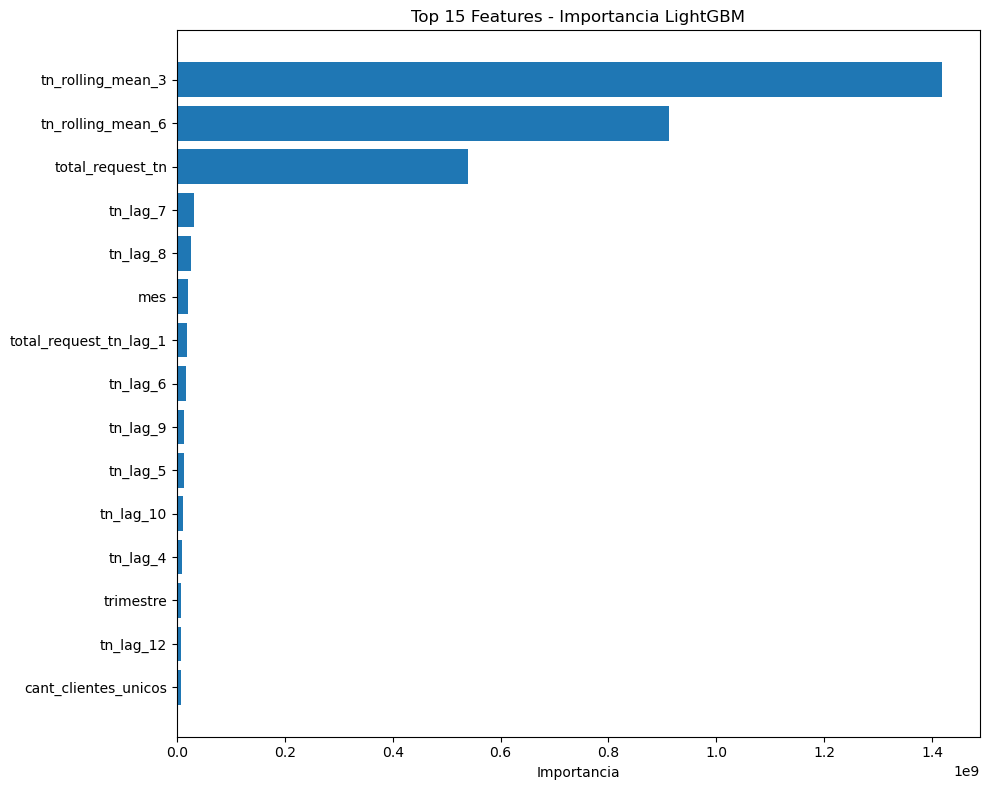


🎯 ANÁLISIS DE PREDICCIONES:
Predicciones mínimas: 0.28
Predicciones máximas: 1388.82
Predicciones promedio: 37.26
Valores reales promedio: 32.24
Predicciones negativas: 0 (0.0%)


In [13]:
# 📊 Análisis de importancia de features
print("ANÁLISIS DE IMPORTANCIA DE FEATURES")
print("="*50)

# Obtener importancia de features
feature_importance = model.feature_importance(importance_type='gain')
feature_names = feature_columns

# Crear DataFrame con importancias
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("🔝 Top 10 features más importantes:")
print(importance_df.head(10))

# Visualizar importancia
plt.figure(figsize=(10, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia')
plt.title('Top 15 Features - Importancia LightGBM')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Análisis de predicciones
print(f"\n🎯 ANÁLISIS DE PREDICCIONES:")
print(f"Predicciones mínimas: {y_pred_val.min():.2f}")
print(f"Predicciones máximas: {y_pred_val.max():.2f}")
print(f"Predicciones promedio: {y_pred_val.mean():.2f}")
print(f"Valores reales promedio: {y_val.mean():.2f}")

# Verificar predicciones negativas
negative_preds = (y_pred_val < 0).sum()
print(f"Predicciones negativas: {negative_preds} ({negative_preds/len(y_pred_val)*100:.1f}%)")

In [14]:
# 🔮 Generar predicciones finales para febrero 2020
print("GENERACIÓN DE PREDICCIONES FINALES")
print("="*50)

# Preparar datos para predicción (últimos datos disponibles de cada producto)
# Necesitamos los datos más recientes para predecir 2 períodos adelante

# Obtener último período disponible para cada producto
ultimo_periodo = data_combined.groupby('product_id')['fecha'].max().reset_index()
ultimo_periodo.columns = ['product_id', 'ultima_fecha']

# Unir con datos completos para obtener features más recientes
datos_prediccion = pd.merge(data_combined, ultimo_periodo, on='product_id')
datos_prediccion = datos_prediccion[datos_prediccion['fecha'] == datos_prediccion['ultima_fecha']].copy()

print(f"📊 Productos para predicción: {len(datos_prediccion)}")
print(f"📅 Período base para predicción: {datos_prediccion['periodo'].value_counts().head()}")

# Preparar features para predicción
X_pred = datos_prediccion[feature_columns].copy()
X_pred = X_pred.fillna(0)

print(f"🔍 Shape de datos de predicción: {X_pred.shape}")
print(f"🔍 Valores nulos en predicción: {X_pred.isnull().sum().sum()}")

# Generar predicciones
predicciones = model.predict(X_pred, num_iteration=model.best_iteration)

# Crear DataFrame de resultados
resultado_lgbm = pd.DataFrame({
    'product_id': datos_prediccion['product_id'].values,
    'tn': predicciones
})

# Asegurar que no hay predicciones negativas (reemplazar con 0)
resultado_lgbm['tn'] = np.maximum(resultado_lgbm['tn'], 0)

print(f"✅ Predicciones generadas para {len(resultado_lgbm)} productos")
print(f"\n📊 Estadísticas de predicciones:")
print(f"  Promedio: {resultado_lgbm['tn'].mean():.2f}")
print(f"  Mediana:  {resultado_lgbm['tn'].median():.2f}")
print(f"  Mínimo:   {resultado_lgbm['tn'].min():.2f}")
print(f"  Máximo:   {resultado_lgbm['tn'].max():.2f}")
print(f"  Std:      {resultado_lgbm['tn'].std():.2f}")

print(f"\nPrimeras 10 predicciones:")
print(resultado_lgbm.head(10))

GENERACIÓN DE PREDICCIONES FINALES
📊 Productos para predicción: 780
📅 Período base para predicción: periodo
201912    780
Name: count, dtype: int64
🔍 Shape de datos de predicción: (780, 74)
🔍 Valores nulos en predicción: 0
✅ Predicciones generadas para 780 productos

📊 Estadísticas de predicciones:
  Promedio: 36.33
  Mediana:  8.98
  Mínimo:   0.68
  Máximo:   1389.72
  Std:      93.35

Primeras 10 predicciones:
   product_id           tn
0       20001  1389.723624
1       20002  1214.473341
2       20003   666.632776
3       20004   482.098775
4       20005   557.388558
5       20006   430.926371
6       20007   362.911277
7       20008   372.151567
8       20009   452.991694
9       20010   226.147834


In [15]:
# 💾 Guardar predicciones y resumen final - GRANULARIDAD POR PRODUCTO
print("GUARDADO DE PREDICCIONES Y RESUMEN - POR PRODUCTO")
print("="*60)

# Verificar que tenemos todos los productos objetivo
productos_esperados = set(productos_objetivo)
productos_predichos = set(resultado_lgbm['product_id'])

print(f"📊 Productos esperados: {len(productos_esperados)}")
print(f"📈 Productos predichos: {len(productos_predichos)}")

# Verificar productos faltantes
productos_faltantes = productos_esperados - productos_predichos
if productos_faltantes:
    print(f"⚠️ Productos faltantes: {len(productos_faltantes)}")
    print(f"Primeros 5 faltantes: {list(productos_faltantes)[:5]}")
    
    # Crear predicciones por defecto para productos faltantes
    predicciones_default = pd.DataFrame({
        'product_id': list(productos_faltantes),
        'tn': [resultado_lgbm['tn'].median()] * len(productos_faltantes)
    })
    
    resultado_lgbm = pd.concat([resultado_lgbm, predicciones_default], ignore_index=True)
    print(f"✅ Agregadas predicciones por defecto para productos faltantes")

# Ordenar por product_id
resultado_lgbm = resultado_lgbm.sort_values('product_id').reset_index(drop=True)

# Guardar archivo
import os
os.makedirs('data', exist_ok=True)
archivo_salida = 'data/pred_lgbm_v3_FE_03_linear_tree_opt_03_36lags_producto_e3.csv'
resultado_lgbm.to_csv(archivo_salida, index=False)

print(f"✅ Predicciones guardadas en: {archivo_salida}")

print(f"\n🔧 CONFIRMACIÓN: Predicciones generadas con hiperparámetros optimizados:")
print("="*70)
print(f"   linear_tree:      {lgb_params['linear_tree']} ⭐ (CARACTERÍSTICA PRINCIPAL)")
print(f"   lambda_l1:        {lgb_params['lambda_l1']:.4f}")
print(f"   lambda_l2:        {lgb_params['lambda_l2']:.4f}")
print(f"   num_leaves:       {lgb_params['num_leaves']}")
print(f"   feature_fraction: {lgb_params['feature_fraction']:.4f}")
print(f"   learning_rate:    {lgb_params['learning_rate']:.4f}")
print(f"   bagging_fraction: {lgb_params['bagging_fraction']:.4f}")
print(f"   bagging_freq:     {lgb_params['bagging_freq']}")
print(f"   min_child_samples: {lgb_params['min_child_samples']}")
print(f"   max_bin:          {lgb_params['max_bin']}")
print("="*70)

# Resumen final del modelo por producto
print(f"\n🎯 RESUMEN FINAL DEL MODELO LGBM CON LINEAR_TREE OPTIMIZADO:")
print(f"⭐ MODELO CON ÁRBOLES LINEALES HÍBRIDOS + OPTUNA (linear_tree=True)")
print(f"📊 Total productos predichos: {len(resultado_lgbm)}")
print(f"📈 Métricas de validación:")
print(f"   MAE:  {mae:.4f}")
print(f"   RMSE: {rmse:.4f}")
print(f"   MAPE: {mape:.2f}%")
print(f"🔧 Features utilizadas: {len(feature_columns)}")
print(f"🌳 Número de árboles: {model.num_trees()}")
print(f"📅 Predicción objetivo: 2 períodos a futuro (Feb 2020)")
print(f"🏭 Granularidad: POR PRODUCTO (agregando clientes)")
print(f"⭐ Tecnología: Árboles lineales híbridos + Optimización Optuna")
print(f"🏆 MAE optimizado: {study.best_value:.4f} → {mae:.4f}")

# Estadísticas de predicciones por producto
print(f"\n📊 ESTADÍSTICAS DE PREDICCIONES POR PRODUCTO:")
print(f"   Promedio por producto: {resultado_lgbm['tn'].mean():.2f}")
print(f"   Mediana por producto:  {resultado_lgbm['tn'].median():.2f}")
print(f"   Std por producto:      {resultado_lgbm['tn'].std():.2f}")
print(f"   Min por producto:      {resultado_lgbm['tn'].min():.2f}")
print(f"   Max por producto:      {resultado_lgbm['tn'].max():.2f}")

print(f"\n📋 Top 5 features más importantes para granularidad por producto:")
for i, row in importance_df.head(5).iterrows():
    print(f"   {row['feature']}: {row['importance']:.0f}")

print(f"\n🔧 RESUMEN DE HIPERPARÁMETROS OPTIMIZADOS PARA LINEAR_TREE:")
print("="*70)
print(f"✅ Los siguientes 9 hiperparámetros fueron optimizados con Optuna:")
print(f"   1. linear_tree:      {lgb_params['linear_tree']} ⭐ (CARACTERÍSTICA PRINCIPAL)")
print(f"   2. lambda_l1:        {lgb_params['lambda_l1']:.4f}")
print(f"   3. lambda_l2:        {lgb_params['lambda_l2']:.4f}")
print(f"   4. num_leaves:       {lgb_params['num_leaves']}")
print(f"   5. feature_fraction: {lgb_params['feature_fraction']:.4f}")
print(f"   6. learning_rate:    {lgb_params['learning_rate']:.4f}")
print(f"   7. bagging_fraction: {lgb_params['bagging_fraction']:.4f}")
print(f"   8. bagging_freq:     {lgb_params['bagging_freq']}")
print(f"   9. min_child_samples: {lgb_params['min_child_samples']}")
print(f"  10. max_bin:          {lgb_params['max_bin']}")
print("="*70)

print(f"\n✅ Modelo LightGBM con LINEAR_TREE + OPTUNA completado exitosamente!")
print(f"⭐ Utilizando árboles lineales híbridos con parámetros optimizados")
print(f"Archivo: {archivo_salida}")

# Mostrar resumen final de hiperparámetros optimizados
print(f"\n🎯 HIPERPARÁMETROS FINALES UTILIZADOS EN LAS PREDICCIONES:")
print("="*70)
print(f"   linear_tree:      {lgb_params['linear_tree']} ⭐ (CARACTERÍSTICA PRINCIPAL)")
print(f"   lambda_l1:        {lgb_params['lambda_l1']:.4f}")
print(f"   lambda_l2:        {lgb_params['lambda_l2']:.4f}")
print(f"   num_leaves:       {lgb_params['num_leaves']}")
print(f"   feature_fraction: {lgb_params['feature_fraction']:.4f}")
print(f"   learning_rate:    {lgb_params['learning_rate']:.4f}")
print(f"   bagging_fraction: {lgb_params['bagging_fraction']:.4f}")
print(f"   bagging_freq:     {lgb_params['bagging_freq']}")
print(f"   min_child_samples: {lgb_params['min_child_samples']}")
print(f"   max_bin:          {lgb_params['max_bin']}")
print("="*70)
print(f"✅ Predicciones generadas usando LINEAR_TREE + valores optimizados por Optuna!")

# Verificar archivo guardado
if os.path.exists(archivo_salida):
    verificacion = pd.read_csv(archivo_salida)
    print(f"\n🔍 Verificación archivo guardado:")
    print(f"   Filas: {len(verificacion)}")
    print(f"   Columnas: {list(verificacion.columns)}")
    print(f"   Primeras 3 filas:")
    print(verificacion.head(3))
    
    print(f"\n📈 Resumen de predicciones por producto:")
    print(f"   Total de toneladas predichas: {verificacion['tn'].sum():.2f}")
    print(f"   Productos con predicción > 0: {(verificacion['tn'] > 0).sum()}")
    print(f"   Productos con predicción = 0: {(verificacion['tn'] == 0).sum()}")

GUARDADO DE PREDICCIONES Y RESUMEN - POR PRODUCTO
📊 Productos esperados: 780
📈 Productos predichos: 780
✅ Predicciones guardadas en: data/pred_lgbm_v3_FE_03_linear_tree_opt_03_36lags_producto_e3.csv

🔧 CONFIRMACIÓN: Predicciones generadas con hiperparámetros optimizados:
   linear_tree:      True ⭐ (CARACTERÍSTICA PRINCIPAL)
   lambda_l1:        1.1858
   lambda_l2:        1.5877
   num_leaves:       26
   feature_fraction: 0.6304
   learning_rate:    0.0427
   bagging_fraction: 0.8798
   bagging_freq:     6
   min_child_samples: 39
   max_bin:          238

🎯 RESUMEN FINAL DEL MODELO LGBM CON LINEAR_TREE OPTIMIZADO:
⭐ MODELO CON ÁRBOLES LINEALES HÍBRIDOS + OPTUNA (linear_tree=True)
📊 Total productos predichos: 780
📈 Métricas de validación:
   MAE:  8.5129
   RMSE: 20.3926
   MAPE: 259.45%
🔧 Features utilizadas: 74
🌳 Número de árboles: 128
📅 Predicción objetivo: 2 períodos a futuro (Feb 2020)
🏭 Granularidad: POR PRODUCTO (agregando clientes)
⭐ Tecnología: Árboles lineales híbridos + Op

In [16]:
# 📊 Resumen final de optimización LINEAR_TREE + Optuna
print("RESUMEN FINAL DE OPTIMIZACIÓN LINEAR_TREE + OPTUNA")
print("="*70)

# Mostrar información del estudio de optimización
print(f"🔍 Detalles de la optimización:")
print(f"   Método de optimización: TPE (Tree-structured Parzen Estimator)")
print(f"   Tecnología base: LINEAR_TREE (Árboles lineales híbridos) ⭐")
print(f"   Hiperparámetros optimizados: 9 parámetros específicos")
print(f"   Número total de trials: {len(study.trials)}")
print(f"   Trials exitosos: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"   Trials podados: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")

print(f"\n🏆 Mejor configuración encontrada:")
print(f"   MAE en validación: {study.best_value:.4f}")
print(f"   Trial número: {study.best_trial.number}")

print(f"\n🎯 VALORES FINALES DE LOS HIPERPARÁMETROS OPTIMIZADOS:")
print("="*70)
final_params = study.best_params
print(f"   1. linear_tree:      True (FIJO - Característica principal) ⭐")
print(f"   2. lambda_l1:        {final_params['lambda_l1']:.4f}")
print(f"   3. lambda_l2:        {final_params['lambda_l2']:.4f}")
print(f"   4. num_leaves:       {final_params['num_leaves']}")
print(f"   5. feature_fraction: {final_params['feature_fraction']:.4f}")
print(f"   6. learning_rate:    {final_params['learning_rate']:.4f}")
print(f"   7. bagging_fraction: {final_params['bagging_fraction']:.4f}")
print(f"   8. bagging_freq:     {final_params['bagging_freq']}")
print(f"   9. min_child_samples: {final_params['min_child_samples']}")
print(f"  10. max_bin:          {final_params['max_bin']}")
print("="*70)

print(f"\n📈 Top 3 trials más exitosos:")
sorted_trials = sorted(study.trials, key=lambda t: t.value if t.value is not None else float('inf'))
for i, trial in enumerate(sorted_trials[:3]):
    if trial.value is not None:
        print(f"   {i+1}. Trial {trial.number}: MAE = {trial.value:.4f}")

print(f"✅ Optimización LINEAR_TREE + Optuna completada exitosamente!")
print(f"⭐ Combinando árboles lineales híbridos con optimización automática")
archivo_salida = 'data/pred_lgbm_v3_FE_03_linear_tree_opt_03_36lags_producto_e3.csv'
print(f"📁 Predicciones finales guardadas en: {archivo_salida}")
print(f"🏆 Modelo final con tecnología avanzada: LINEAR_TREE + OPTUNA + 36 LAGS")
print(f"🎲 Reproductibilidad garantizada con SEED={SEED}")

RESUMEN FINAL DE OPTIMIZACIÓN LINEAR_TREE + OPTUNA
🔍 Detalles de la optimización:
   Método de optimización: TPE (Tree-structured Parzen Estimator)
   Tecnología base: LINEAR_TREE (Árboles lineales híbridos) ⭐
   Hiperparámetros optimizados: 9 parámetros específicos
   Número total de trials: 500
   Trials exitosos: 500
   Trials podados: 0

🏆 Mejor configuración encontrada:
   MAE en validación: 8.0726
   Trial número: 417

🎯 VALORES FINALES DE LOS HIPERPARÁMETROS OPTIMIZADOS:
   1. linear_tree:      True (FIJO - Característica principal) ⭐
   2. lambda_l1:        1.1858
   3. lambda_l2:        1.5877
   4. num_leaves:       26
   5. feature_fraction: 0.6304
   6. learning_rate:    0.0427
   7. bagging_fraction: 0.8798
   8. bagging_freq:     6
   9. min_child_samples: 39
  10. max_bin:          238

📈 Top 3 trials más exitosos:
   1. Trial 417: MAE = 8.0726
   2. Trial 448: MAE = 8.1720
   3. Trial 461: MAE = 8.2642
✅ Optimización LINEAR_TREE + Optuna completada exitosamente!
⭐ Combi

In [17]:
# 🎲 Documentar información de reproductibilidad
print("INFORMACIÓN DE REPRODUCTIBILIDAD")
print("="*50)

import json
import os
from datetime import datetime

# Información completa de reproductibilidad
reproducibility_info = {
    "model_info": {
        "model_type": "LightGBM with Linear Tree",
        "optimization": "Optuna TPE",
        "version": "v3_linear_tree_opt",
        "created_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    },
    "seeds": {
        "main_seed": SEED,
        "numpy_seed": SEED,
        "random_seed": SEED,
        "optuna_seed": SEED,
        "lgb_random_state": lgb_params['random_state'],
        "lgb_bagging_seed": lgb_params['bagging_seed'],
        "lgb_feature_fraction_seed": lgb_params['feature_fraction_seed']
    },
    "optimization_results": {
        "best_trial": study.best_trial.number,
        "best_mae": study.best_value,
        "total_trials": len(study.trials),
        "successful_trials": len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
    },
    "best_hyperparameters": {
        "linear_tree": lgb_params['linear_tree'],
        "lambda_l1": lgb_params['lambda_l1'],
        "lambda_l2": lgb_params['lambda_l2'],
        "num_leaves": lgb_params['num_leaves'],
        "feature_fraction": lgb_params['feature_fraction'],
        "learning_rate": lgb_params['learning_rate'],
        "bagging_fraction": lgb_params['bagging_fraction'],
        "bagging_freq": lgb_params['bagging_freq'],
        "min_child_samples": lgb_params['min_child_samples'],
        "max_bin": lgb_params['max_bin']
    },
    "final_metrics": {
        "validation_mae": mae,
        "validation_rmse": rmse,
        "validation_mape": mape,
        "num_trees": model.num_trees()
    }
}

# Guardar información de reproductibilidad
os.makedirs('data', exist_ok=True)
with open('data/reproducibility_info_lgbm_v3_FE_03_linear_tree_opt_36lags_e3.json', 'w') as f:
    json.dump(reproducibility_info, f, indent=2)

print("🎲 SEMILLAS UTILIZADAS:")
print(f"   Semilla principal: {SEED}")
print(f"   NumPy seed: {SEED}")
print(f"   Random seed: {SEED}")
print(f"   Optuna sampler seed: {SEED}")
print(f"   LightGBM random_state: {lgb_params['random_state']}")
print(f"   LightGBM bagging_seed: {lgb_params['bagging_seed']}")
print(f"   LightGBM feature_fraction_seed: {lgb_params['feature_fraction_seed']}")

print(f"\n✅ Información de reproductibilidad guardada en:")
print(f"   data/reproducibility_info_lgbm_v3_FE_03_linear_tree_opt_36lags_e3.json")

print(f"\n🔄 PARA REPRODUCIR EXACTAMENTE ESTOS RESULTADOS:")
print(f"   1. Usar SEED = {SEED}")
print(f"   2. Configurar todas las semillas antes de entrenar")
print(f"   3. Usar los mismos hiperparámetros guardados")
print(f"   4. Usar la misma división temporal de datos")
print(f"   5. Ejecutar {n_trials} trials de Optuna con la misma semilla")

print(f"\n🎯 MODELO COMPLETAMENTE REPRODUCIBLE!")
print(f"⭐ LINEAR_TREE + OPTUNA + SEMILLAS = Resultados consistentes")

INFORMACIÓN DE REPRODUCTIBILIDAD
🎲 SEMILLAS UTILIZADAS:
   Semilla principal: 42
   NumPy seed: 42
   Random seed: 42
   Optuna sampler seed: 42
   LightGBM random_state: 42
   LightGBM bagging_seed: 42
   LightGBM feature_fraction_seed: 42

✅ Información de reproductibilidad guardada en:
   data/reproducibility_info_lgbm_v3_FE_03_linear_tree_opt_36lags_e3.json

🔄 PARA REPRODUCIR EXACTAMENTE ESTOS RESULTADOS:
   1. Usar SEED = 42
   2. Configurar todas las semillas antes de entrenar
   3. Usar los mismos hiperparámetros guardados
   4. Usar la misma división temporal de datos
   5. Ejecutar 500 trials de Optuna con la misma semilla

🎯 MODELO COMPLETAMENTE REPRODUCIBLE!
⭐ LINEAR_TREE + OPTUNA + SEMILLAS = Resultados consistentes
